In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# LOAD

Importo i profili di carico. Bisogna aggregare la potenza attiva a intervalli di 15 minuti.

In [13]:
path_root = 'Profili/Carichi/Appliances/'

### doublepolecontactor-I

In [14]:
doublepolecontactor_i = pd.read_csv(path_root + 'doublepolecontactor-I.csv')

In [15]:
doublepolecontactor_i.head()

timestamp  active_power  reactive_power  apparent_power  \
0  2017-10-30 20:54:11-02     -0.575436        -22.4346         22.4420   
1  2017-10-30 20:54:12-02      0.164410         22.4414         22.4420   
2  2017-10-30 20:54:13-02      0.246615        -22.2762         22.2776   
3  2017-10-30 20:54:14-02     -0.739846        -22.0185         22.0309   
4  2017-10-30 20:54:15-02     -0.082205        -22.4419         22.4421   

    current  voltage  
0  0.095952  234.072  
1  0.095952  234.057  
2  0.095326  234.043  
3  0.094388  234.095  
4  0.095952  234.050

Elimino le colonne che non mi interessano

In [16]:
doublepolecontactor_i = doublepolecontactor_i.drop(columns = ['reactive_power', 'apparent_power', 'current', 'voltage'])

Elimino la desinenza "-02" e "-03" che è presente alla fine del timestamp e lo converto al formato datetime

In [17]:
#doublepolecontactor_i['temp'] = doublepolecontactor_i['timestamp'].str.rsplit('-', 1, expand=True)[1]
doublepolecontactor_i['timestamp'] = doublepolecontactor_i['timestamp'].str.rsplit('-', 1, expand=True)[0]
doublepolecontactor_i['timestamp'] = pd.to_datetime(doublepolecontactor_i['timestamp'], infer_datetime_format=True)
doublepolecontactor_i.head()

timestamp  active_power
0 2017-10-30 20:54:11     -0.575436
1 2017-10-30 20:54:12      0.164410
2 2017-10-30 20:54:13      0.246615
3 2017-10-30 20:54:14     -0.739846
4 2017-10-30 20:54:15     -0.082205

Estraggo la data dal timestamp. Mi servirà per raggruppare nella groupby

In [18]:
doublepolecontactor_i['date'] = doublepolecontactor_i['timestamp'].dt.date
#doublepolecontactor_i['time'] = doublepolecontactor_i['timestamp'].dt.time

Controllo quanti `NaN` ho all'interno del dataframe

In [8]:
doublepolecontactor_i.active_power.isna().sum()

0

In [9]:
doublepolecontactor_i.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5504827 entries, 0 to 5504826
Data columns (total 3 columns):
timestamp       datetime64[ns]
active_power    float64
date            object
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 126.0+ MB


Creo gli intervalli da passare alla cut con frequenza di 15 min

In [10]:
intervals = pd.date_range("00:00:00", "23:59:59", freq="15min")

Trasformo in interi la stringhificazione dell'orario (nella forma HHMMSS). Inoltre, vista la frequenza di 15 minuti, non mi viene considerato l'ultimo intervallo dalle 23:45 alle 00:00. Lo aggiungo quindi a mano (sottoforma di 240000, ovvero 24:00)

In [11]:
intervals = intervals.to_series()
intervals = intervals.dt.strftime('%H%M%S').astype(int)
intervals = intervals.append(pd.Series(['240000']).astype(int))
intervals

2020-02-26 00:00:00         0
2020-02-26 00:15:00      1500
2020-02-26 00:30:00      3000
2020-02-26 00:45:00      4500
2020-02-26 01:00:00     10000
                        ...  
2020-02-26 23:00:00    230000
2020-02-26 23:15:00    231500
2020-02-26 23:30:00    233000
2020-02-26 23:45:00    234500
0                      240000
Length: 97, dtype: int64

Utilizzo la cut sulla colonna timestamp stringhificando il datetime nel formato HHMMSS e passando come bins l'array con gli intervalli creato in precedenza. Utilizzo `labels=False` per assegnare alla colonna `t` il numero dell'intervallo (da 0 a 95) e non la label che corrisponde all'intervallo (l'intervallo 0 corrisponde alla label 0-1500, l'intervallo 1 corrisponde a 1500-3000 e via dicendo)

In [12]:
doublepolecontactor_i['t'] = pd.cut(doublepolecontactor_i['timestamp'].dt.strftime('%H%M%S').astype(int), \
           bins=intervals, labels=False)

In [13]:
doublepolecontactor_i.head(11100)

timestamp  active_power        date     t
0     2017-10-30 20:54:11     -0.575436  2017-10-30  83.0
1     2017-10-30 20:54:12      0.164410  2017-10-30  83.0
2     2017-10-30 20:54:13      0.246615  2017-10-30  83.0
3     2017-10-30 20:54:14     -0.739846  2017-10-30  83.0
4     2017-10-30 20:54:15     -0.082205  2017-10-30  83.0
...                   ...           ...         ...   ...
11095 2017-10-30 23:59:08   1190.990000  2017-10-30  95.0
11096 2017-10-30 23:59:09   1216.960000  2017-10-30  95.0
11097 2017-10-30 23:59:10   1222.230000  2017-10-30  95.0
11098 2017-10-30 23:59:11   1195.510000  2017-10-30  95.0
11099 2017-10-30 23:59:12   1195.510000  2017-10-30  95.0

[11100 rows x 4 columns]

Faccio la groupby per data e per intervallo. Utilizzando `sum()` sommo tutte le potenze attive per dato giorno e dato intervallo (in poche parole: aggrego a 15 minuti)

In [14]:
doublepolecontactor_i = doublepolecontactor_i.groupby(['date','t']).sum()

Controllo che non ci siano `NaN` e stampo per vedere il risultato

In [15]:
doublepolecontactor_i.active_power.isna().sum()

0

In [16]:
doublepolecontactor_i.head()

active_power
date       t                 
2017-10-30 83.0      0.822054
           84.0    -19.235985
           85.0      6.412019
           86.0      2.959404
           87.0    -35.677042

Il dataframe sarebbe già pronto, ma come si può vedere dall'istruzione per grafiacare qui sotto estrarre i dati da un multindex può risultare complesso. Utilizzo quindi il pivoting

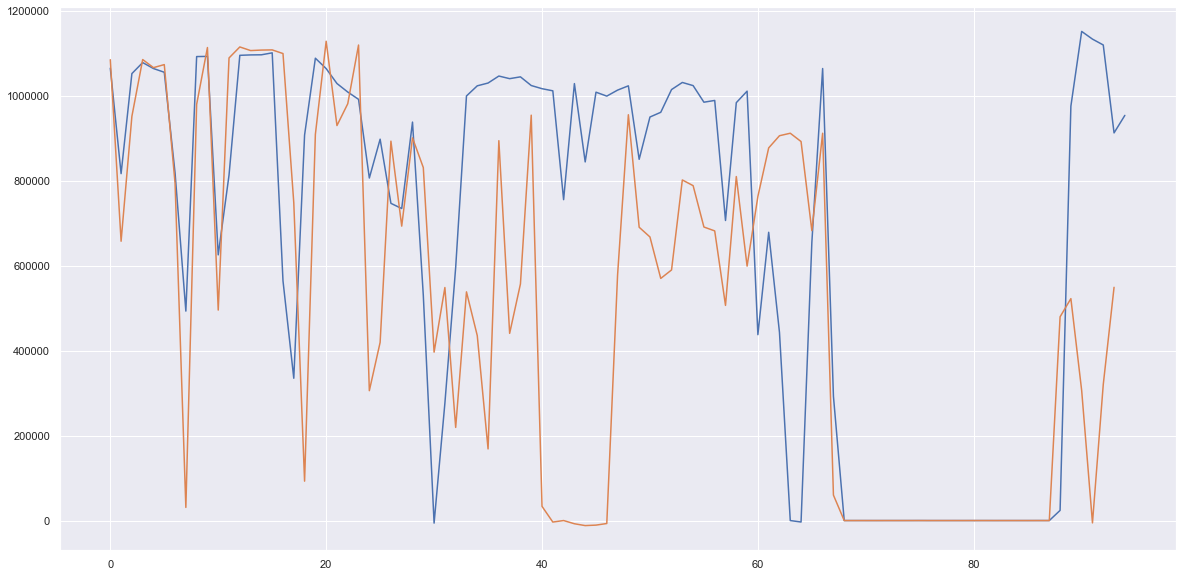

In [17]:
plt.figure(figsize=(20,10))
plt.plot(doublepolecontactor_i.iloc[13:108, :].index.get_level_values(1), doublepolecontactor_i.iloc[13:108, :])
plt.plot(doublepolecontactor_i.iloc[109:203, :].index.get_level_values(1), doublepolecontactor_i.iloc[109:203, :])

Per effettuare l'operazione di pivoting devo prima resettare il multindex con `reset_index()`. Poi utilizzo la funzione `pivot()` usando come righe gli elementi della colonna `date` e mettendo sull'asse delle colonne gli intervalli di tempo `t` da 0 a 95

In [18]:
df_pivot = doublepolecontactor_i.reset_index()
df_pivot = df_pivot.pivot(index='date', columns='t', values='active_power')

In [19]:
df_pivot.head()

t                   0.0           1.0           2.0           3.0   \
date                                                                 
2017-10-30           NaN           NaN           NaN           NaN   
2017-10-31  1.065225e+06  8.168371e+05  1.052420e+06  1.078367e+06   
2017-11-01  1.085117e+06  6.577114e+05  9.517657e+05  1.085519e+06   
2017-11-02  1.042291e+06  1.079180e+06  1.146853e+06  1.136099e+06   
2017-11-03 -2.877176e+00  1.808523e+00 -2.589462e+01 -1.438592e+01   

t                   4.0           5.0           6.0           7.0   \
date                                                                 
2017-10-30           NaN           NaN           NaN           NaN   
2017-10-31  1.064331e+06  1.055570e+06  8.186376e+05  4.932074e+05   
2017-11-01  1.066453e+06  1.073613e+06  7.942501e+05  3.088266e+04   
2017-11-02  1.127490e+06  1.125430e+06  1.114039e+06  1.113420e+06   
2017-11-03 -1.808512e+01 -2.885402e+01  8.219290e-02 -9.371386e+00   

t                   8.0           9.0   ...       86.0       87.0  \
date                                    ...                         
2017-10-30           NaN           NaN  ...   2.959404 -35.677042   
2017-10-31  1.092516e+06  1.092913e+06  ...   6.576403  -6.905239   
2017-11-01  9.799855e+05  1.113781e+06  ... -12.824014  -4.356849   
2017-11-02  1.101282e+06  1.077154e+06  ... -52.857942  -7.809474   
2017-11-03 -2.959388e+01 -4.603507e+00  ...  17.263088  -2.055144   

t                    88.0          89.0          90.0          91.0  \
date                                                                  
2017-10-30  164646.105604  1.139579e+06  1.138301e+06  1.135294e+06   
2017-10-31   23930.653141  9.757858e+05  1.151754e+06  1.133607e+06   
2017-11-01  479780.130352  5.225405e+05  3.060928e+05 -5.515801e+03   
2017-11-02      27.292096 -2.285305e+01 -1.709867e+01 -6.823033e+00   
2017-11-03     -26.223479  7.581859e+05  2.705519e+04  9.778702e+05   

t                   92.0          93.0          94.0          95.0  
date                                                                
2017-10-30  9.202588e+05  1.107396e+06  1.099319e+06  1.080010e+06  
2017-10-31  1.119790e+06  9.127865e+05  9.540485e+05  1.091293e+06  
2017-11-01  3.202897e+05  5.492093e+05  7.041864e+05  7.775027e+05  
2017-11-02  1.611222e+01 -3.485498e+01 -9.946840e+00 -4.554167e+01  
2017-11-03  7.811926e+05  7.632539e+05  1.036261e+06  9.963800e+05  

[5 rows x 96 columns]

Ora graficare diventa molto più immediato

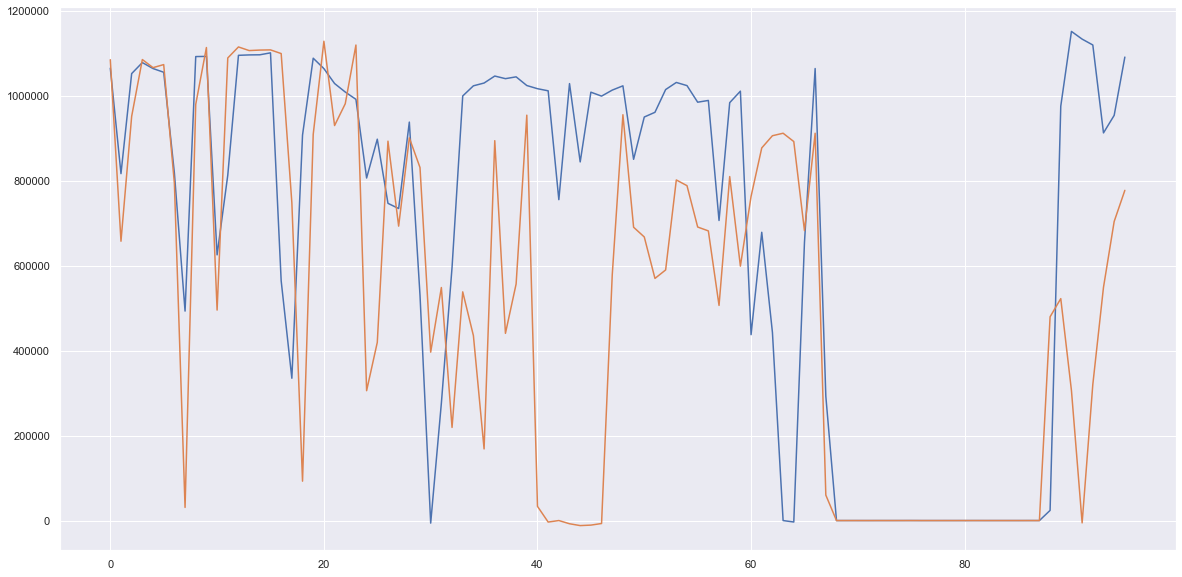

In [20]:
plt.figure(figsize=(20,10))
plt.plot(df_pivot.iloc[1, :])
plt.plot(df_pivot.iloc[2, :])

Problema: noto che anche aggregando a 15 minuti alcuni valori di potenza attiva sono negativi, il che significa che in quei dati istanti il macchinario produce energia anziché utilizzarla. Non credo sia giusto

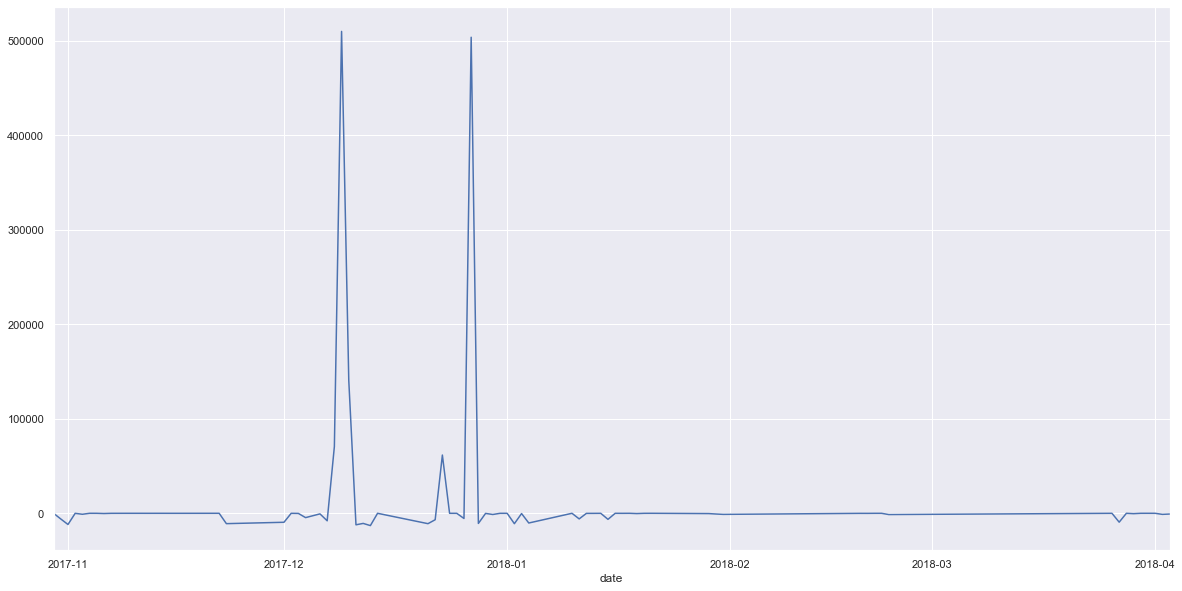

In [21]:
df_pivot.min(axis=1).plot(figsize=(20,10))

Come concordato con Allegra, trasformo i calori negativi in zero

In [22]:
df_pivot[df_pivot < 0] = 0

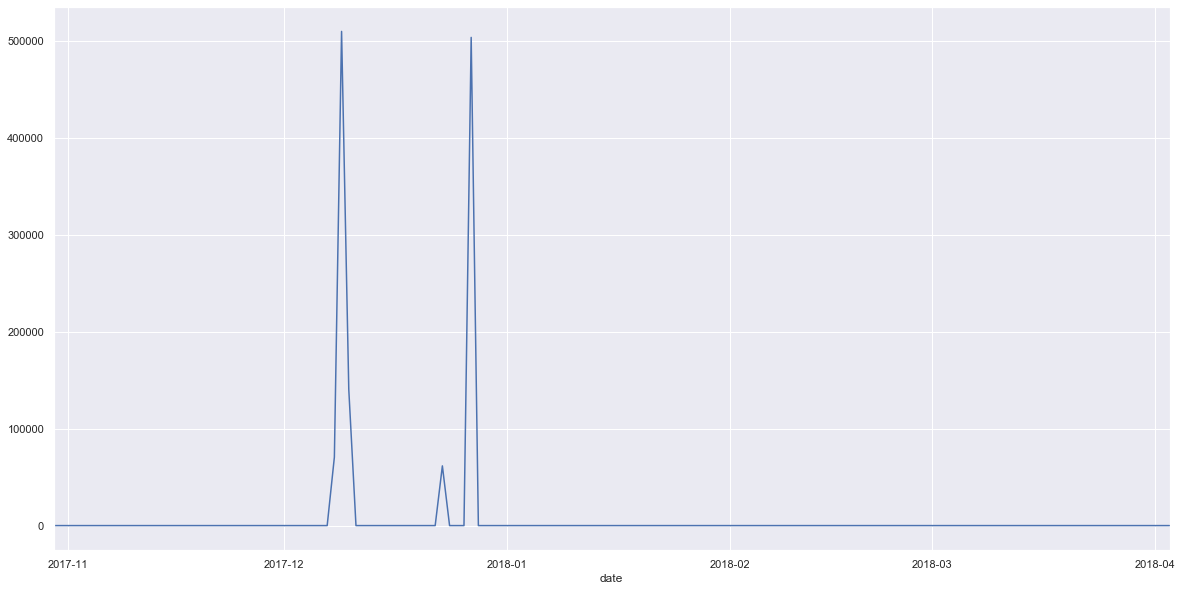

In [23]:
df_pivot.min(axis=1).plot(figsize=(20,10))

Altro problema: nel dataset, in alcubni giorni non sono presenti valori per tutti gli istanti temporali. Ciò significa, ad esempio, che se per la data 2017-12-11 non sono presenti i valori per gli orari compresi tra 00:15 e 01:00 nella tabella pivot avrò `NaN` in corrispondenza degli intervalli per cui questi valori non sono presenti

In [24]:
df_pivot.min(axis=1, skipna=False).isna().sum()

38

Infatti........

In [25]:
df_pivot.iloc[10, 20:80]

t
20.0    1.001035e+06
21.0    1.005147e+06
22.0    9.934406e+05
23.0    9.831150e+05
24.0    9.708429e+05
25.0    9.749763e+05
26.0    9.724769e+05
27.0    9.643714e+05
28.0    1.002075e+06
29.0    1.336250e+05
30.0             NaN
31.0             NaN
32.0             NaN
33.0             NaN
34.0             NaN
35.0             NaN
36.0             NaN
37.0             NaN
38.0             NaN
39.0             NaN
40.0             NaN
41.0             NaN
42.0             NaN
43.0             NaN
44.0             NaN
45.0             NaN
46.0             NaN
47.0             NaN
48.0             NaN
49.0             NaN
50.0             NaN
51.0             NaN
52.0             NaN
53.0             NaN
54.0             NaN
55.0             NaN
56.0             NaN
57.0             NaN
58.0             NaN
59.0             NaN
60.0             NaN
61.0             NaN
62.0             NaN
63.0             NaN
64.0             NaN
65.0             NaN
66.0             NaN
67.0       